## Prepping the Data

Loading Software

In [4]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler



Loading Data

In [ ]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
"""
The Below file which I used was too big to upload to github so a saved version of a cleaned data set is used
file ='vehicles.csv'

"""
file = 'vehicles.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)



#Open data
auto_data.head(5)

Exploratory Data1

In [ ]:
#Print the columns names of the entire dataframe
print(auto_data.columns)
# Review the column names, null value counts and data types of your data frame.
auto_data.info()


Variables drop
#url   - We will not be using urls in this study, 
#region_url   - We have already have region
#image_url #We do not need photos at the moment 
#county    #there is no non 0 data points there

In [ ]:
auto_data= auto_data.drop(columns=['url', 'region_url', 'image_url', 'county'])
print(auto_data.columns)


#known main points for an auto sale condition, age, mileage, type of car if the cars don't have it we don't want it
auto_data = auto_data[auto_data['condition'].notna()]  #if condition is unknown from wreck to clean we don't need itnew_file = 'autosub.csv'
auto_data = auto_data[auto_data['year'].notna()]  #if we don't know model year we don't know age
auto_data = auto_data[auto_data['odometer'].notna()]  #odometer measures mileage
auto_data = auto_data[auto_data['model'].notna()]  #we don't know the model car we don't know the car
auto_data = auto_data[auto_data['price'].notna()]  #we don't know the model car we don't know the car



Transforming Rules: Common Sense

* Cylinders can be numeric
* Manufacturer names should be consistent




In [ ]:
#Turn Cylinder column from string to numeric
auto_data['cyl'] = auto_data['cylinders']
auto_data['cyl'] = auto_data['cyl'].replace('other', np.nan)
auto_data['cyl'] = auto_data['cyl'].astype(str).str[0:2]
auto_data['cyl'] = auto_data['cyl'].str.strip()
auto_data['cyl'] = auto_data['cyl'].replace('na', np.nan)
auto_data['cyl'] = pd.to_numeric(auto_data['cyl'])
auto_data['cylinders']= auto_data['cyl']
auto_data= auto_data.drop(['cyl'], axis=1)

#plot Cylinders
plt.title("Numerical Cylinders")
hist = auto_data.cylinders.hist(bins=10)

In [ ]:
#Neaten Strings
#Fix manufacturer
auto_data['manufacturer']= auto_data['manufacturer'].str.title().str.strip()
auto_data['manufacturer']= auto_data['manufacturer'].str.replace(' ', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('rover' , 'land-rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('land-land' , 'land')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('porche', 'porsche')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('---', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('--', '-')


#Fix model
auto_data['model']= auto_data['model'].str.title().str.strip()
auto_data['model']= auto_data['model'].str.replace(' ', '-')
auto_data['model']= auto_data['model'].str.replace('---', '-')
auto_data['model']= auto_data['model'].str.replace('--', '-')

#States are state codes
auto_data['state'] = auto_data['state'].str.upper().str.strip()

#If no paint color is given its unlisted and its unrealistc to try to impute it
auto_data['paint_color'] = auto_data['paint_color'].fillna('unlisted')


Cleaning Rules: Common Sense

* This study is not looking at over luxury cars/ antique cars  so 
    * None of the vehicles should have a price greater than half a million
* This study is not looking at motorbikes or bus's 
    * we don't need harley davidson's or henessey's 
    *
* This study is not looking at junker cars so we do not need vehicles 
    * of a value of a 100 dollars or less
    * with over a half milion miles on them
    * are of poor condition
    * older than 10 years old (we are also not looking at antique cars
    * that has a condition/title status is better than salvage 
* Cleaning Obvious errors:
    * We are looking at used vehicles so the vehicles age should be greater than 1 year
* We do not need to take into consideration vehicles older than 10 years old. 




In [ ]:
# If we are dealing with a vehicle with over a half milion miles we have more problem
auto_data = auto_data[(auto_data.odometer< 500000)] 


#This study is not look at eather junkers or antiques so 
#a: age has to be greater than 0 and less than 11 years
#b: price has to be greater than $100 and less than half million
#c: mileage has to be greater than or equal to 0 and less than half million

auto_data['age'] = 2020-auto_data['year']
auto_data = auto_data[(auto_data.age > 0) & (auto_data.age <= 10)]
auto_data = auto_data[(auto_data.price >= 100) & (auto_data.price <= 500000)]
auto_data = auto_data[(auto_data.odometer >= 0) & (auto_data.odometer <= 500000)]


print(f"Maximum price: $ {auto_data.price.max()} \nMinimum price: $ {auto_data.price.min()} ")
print(f"Maximum age:  {auto_data.age.max()} years \nMinimum age: {auto_data.age.min()} years ")
print(f"Maximum mileage: {auto_data.odometer.max()} \nMinimum mileage: {auto_data.odometer.min()} ")


In [ ]:
#This study is not look junkers so condition and title_ status is better than salvage

#See Status of Vehicles
auto_data.title_status.value_counts().plot.bar()
plt.title("Status of the vehicles")
plt.show()


In [ ]:
#See Condition of Vehicles

auto_data.condition.value_counts().plot.bar()
plt.title("Condition of the vehicles")
plt.show()

In [ ]:
#This study is not look junkers so condition and title_ status is better than salvage

idx1 = auto_data[auto_data["condition"] == "salvage"].index

for w in ["salvage","lien","missing","parts only", 'rebuilt']:
    idx2 = auto_data[auto_data["title_status"] == w].index
    idx1 = idx1.union(idx2)
    
auto_data.drop(idx1, axis = 0, inplace = True)

In [ ]:
#We are not looking at motorbikes

#Graph manufacturers

auto_data.manufacturer.value_counts().plot.bar()
plt.title("manufacturer of the vehicles")
plt.show()

In [ ]:

#We are not looking at motorbikes
auto_data = auto_data[auto_data.manufacturer != 'Harley-Davidson']
auto_data = auto_data[auto_data.manufacturer != 'Hennessey']

In [ ]:
#We are not looking at buses
#Graph type

auto_data.type.value_counts().plot.bar()
plt.title("type")
plt.show()

In [ ]:
#We are not looking at bus
auto_data = auto_data[auto_data.type != 'bus']


In [ ]:
#Create Make Model Model Year Key (Useful for later)
auto_data['mmy_a']=auto_data['manufacturer']+' '+auto_data['model']+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a']=auto_data['mmy_a'].str.title()

auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model'].str.split(' ').str[0]+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a2']=auto_data['mmy_a2'].str.title()


In [ ]:
auto_data.info()

In [ ]:
auto_data.describe()

Save Data

In [ ]:
sub_file = 'data'
new_file = 'auto_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Categorical Data
We want data on what segment the vehicle is in as that might change the prices signicantly.
We got this data from back4app an open data source.
Website: https://www.back4app.com/database/back4app/car-make-model-dataset

In [ ]:
#Get Categorical Data

where = urllib.parse.quote_plus("""
{
    "Category": {
        "$exists": true
    },
    "Year": {
        "$gte": 2010
    }
}
""")
url = 'https://parseapi.back4app.com/classes/Carmodels_Car_Model_List?limit=5000&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'pozCwVISt2yfzi2wJjwo0JiMIJclsUAOchP4AuJO', # This is your app's application id
    'X-Parse-REST-API-Key': 'Jtc8r91VIJOizG8ReKkaseZcugQjAx4vG1WKbJye' # This is your app's REST API key
}
data_json = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need


#import collections

In [ ]:
#the above data was too nested a dictionaries listed in a list that was in a list that was a dictionary
print(type(data_json))
list_values = [ v for v in data_json.values() ] #undoes dictionary

list_value_items = [y for x in list_values for y in x] # undoes list

cat_data = pd.DataFrame.from_dict(list_value_items) #turns list of dictionaries into data frame


In [ ]:
#we don't need object id or created at
cat_data= cat_data.drop(['objectId', 'createdAt'], axis=1)
print(cat_data.head())
cat_data.describe()

In [ ]:
#Neaten Strings
cat_data['Make'] = cat_data['Make'].str.title().str.strip()
cat_data['Make']= cat_data['Make'].str.replace(' ', '-') 
cat_data['Model'] = cat_data['Model'].str.title().str.strip()
cat_data['Model']= cat_data['Model'].str.replace(' ', '-') 

#Create Key
cat_data['mmy']=cat_data['Make']+' '+cat_data['Model'].str.strip()+ ' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy']= cat_data['mmy'].str.title()

cat_data['mmy2']=cat_data['Make']+' '+cat_data['Model'].str.split(' ').str[0]+' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy2']= cat_data['mmy2'].str.title()



In [ ]:
cat_data.info()

In [ ]:

#Save Categorical Data
sub_file = 'data'
new_file = 'cat_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
cat_data.to_csv(new_file_name_path, index=False)

## auto_data2

## Find MSRP data
The original price of the car will heavily effect the older price. Let's bring that out.
This data is a downloaded file from https://www.kaggle.com/CooperUnion/cardataset . This data was obtained by scraping edmunds (a car rating website) and twitter.

In [ ]:
# Create the list of file names: filenames
file ='msrp.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
msrp_data= pd.read_csv(file_name_path)

#Open data
msrp_data.head(5)

In [ ]:
#From the previous cleaning rules we eliminate vehicles with value of over half a million and an age over 10 years

print(f"Maximum MSRP: {msrp_data.MSRP.max()} \nMinimum MSRP: {msrp_data.MSRP.min()} ")
# If we are dealing with a vehicle with an MSRP over half milion miles we have more problem
msrp_data = msrp_data[(msrp_data.MSRP< 500000 )] 
print(f"Maximum Year: {msrp_data.Year.max()} \nMinimum Year: {msrp_data.Year.min()} ")
# We only need vehicles with over a 2009 MY
msrp_data = msrp_data[(msrp_data.Year> 2009 )] 



In [ ]:
# Clean Strings/ Neaten Strings
msrp_data['Make']= msrp_data['Make'].str.title().str.strip()
msrp_data['Make']= msrp_data['Make'].str.replace(' ', '-')
msrp_data['Model']= msrp_data['Model'].str.title().str.strip()
msrp_data['Model']= msrp_data['Model'].str.replace(' ', '-')

#Make Keys
msrp_data['mmy']=msrp_data['Make']+' '+msrp_data['Model']+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy']= msrp_data['mmy'].str.title()
msrp_data['mmy2']=msrp_data['Make']+' '+msrp_data['Model'].str.split(' ').str[0]+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy2']= msrp_data['mmy2'].str.title()



In [ ]:
MSRP_dict = msrp_data.groupby(['Make', 'Model', 'Year', 'mmy', 'mmy2'])['MSRP'].mean().reset_index()

In [ ]:
MSRP_dict.info()

In [ ]:
sub_file = 'data'
new_file = 'msrp.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
msrp_data.to_csv(new_file_name_path, index=False)

## Find State data
We can use geographic data to find other data we need. Two things that effect prices is the amount of money people make so let's include that
Similarly car prices are often influenced by gas prices so we will include that as well

Gas prices come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date availble from the scraping of the craiglist data which was Feb 22
https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/

This data for household income was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is reccomend by theWSJ and the NYT. This has already been done

# Merging Data

In [ ]:
## Merging Auto and MSRP

#Create Dictionaries to map with

First the MMY
* automobiles models are referenced by its a) manufacture b) model name, and C) model year (otherwise known as the MMY)
* Each mmy has an average MSRP to go with it and a specific groups of catehories can be in 
    * (ex a camry can be sedan or hatchback it can't be a pickup)
* We will therefore use the MMYas a key to map the MSRP and category to the main data set

Issue: Model names of automobile
* The trim of a model is referencing a set of additional features comes with (example Camry Lux has leather seats)
* The trim changes the price of a vehicle
* Therefore sometimes sellers will add the trim after the model design to give a better idea of what they are selling
* This leads to the model name not being consistent across tables.

Fixing the Issue
* To ensure better mapping we will therefore use 2 keys 
* The first key will match the full name of the model for the mmy
* The second key will match the first word name of the model for the mmy
* We will try to map to first the key if a map isn't reached we use the results from the second key.
* both keys include the manufacturer and model year



In [ ]:
#Create Dictionaries to map with


#create mmy key2 for autos
auto_data['model2']= auto_data['model'].str.split(' ').str[0]
auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model2']+ ' '+ auto_data['year'].astype(int).astype(str)

#auto_dictionary
auto_dict= auto_data[['manufacturer', 'model', 'year', 'mmy_a', 'mmy_a2']].drop_duplicates(keep='last')

#MSRP_dictionary_1 has only the first key
MSRP_dict1 = MSRP_dict[['mmy', 'MSRP']]

#MSRP_dictionary_2 has only the second key
MSRP_dict2= MSRP_dict[['mmy2', 'MSRP']]
MSRP_dict2['MSRP_vague'] = MSRP_dict2['MSRP']
MSRP_dict2= MSRP_dict2.drop(columns= ['MSRP'])



In [ ]:
#Merge auto_dict and MSRP dictionary 1 into df1 using the 1st key
df1= pd.merge(auto_dict, MSRP_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )
#Merge dictionary3 and MSRP dictionary 2 into auto_msrp_dictionary using the second key
a_m_dict= pd.merge(df1, MSRP_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#fill any null results in MSRP from first key map by results in second key
a_m_dict['MSRP']=a_m_dict['MSRP'].fillna(a_m_dict['MSRP_vague']) 

#drop duplicates
a_m_dict= a_m_dict[['mmy_a', 'mmy', 'mmy2','MSRP']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [ ]:
#Cat_dictionary_1 has only the first key
cat_dict= cat_data[['Make', 'Model', 'Year', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['Make', 'Model', 'Year', 'mmy', 'mmy2'], keep='last')
cat_dict1 = cat_dict[['mmy', 'Category']]


#Cat_dictionary_2 has only the second key
cat_dict2= cat_dict[['mmy2', 'Category']]
cat_dict2['Category_vague'] = cat_dict2['Category']
cat_dict2= cat_dict2.drop(columns= ['Category'])


In [ ]:
#Merge auto dictionary and cat dictionary 1 into dictionary into df1 using the first key
df1= pd.merge(auto_dict, cat_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )

#Merge dictionary3 and cat dictionary 2 into auto_cat_dictionary using the second key
a_c_dict= pd.merge(df1, cat_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#Fill in blanks in the Category left from the first key with results from the second key (if any)
a_c_dict['Category']=a_c_dict['Category'].fillna(a_c_dict['Category_vague']) 


#drop duplicates 
a_c_dict= a_c_dict[['mmy_a', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [ ]:
print(a_c_dict.info())
print(a_m_dict.info())

In [ ]:
#Merge Cat and MSRP
#We still have two keys mmy_a and mmy

a_m_dict_1= a_m_dict[['mmy_a', 'MSRP']].dropna()
a_m_dict_2= a_m_dict[['mmy', 'MSRP']].dropna()
a_m_dict_3= a_m_dict[['mmy2', 'MSRP']].dropna()

a_m_dict_2= a_m_dict_2.rename(columns={"MSRP": "MSRP_2"})
a_m_dict_3= a_m_dict_3.rename(columns={"MSRP": "MSRP_3"})


In [ ]:
#Merge a_c and a_m dict on first key
df1= pd.merge(a_c_dict, a_m_dict_1, on='mmy_a', how='outer')


In [ ]:
#Merge a_c and a_m dict on second key
df2 = pd.merge(df1,  a_m_dict_2, left_on='mmy', right_on='mmy', how='outer' )


In [ ]:
#Merge a_c and a_m dict on third key
a_m_c_dict = pd.merge(df2,  a_m_dict_3, on='mmy2', how='outer' )
a_m_c_dict.info()



In [ ]:
#Fill in blanks in the MSRP left from 1st key with results from the 2nd and 3rd key (if any)
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_2']) 
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_3']) 

#drop duplicates
a_m_c_dict= a_m_c_dict[['mmy_a', 'MSRP', 'Category']].drop_duplicates(subset=['mmy_a'], keep= 'last' )

#drop if missing 'mmy_a'
a_m_c_dict = a_m_c_dict[a_m_c_dict['mmy_a'].notna()]


Merge Dictionaries with auto

In [ ]:
z= pd.merge(auto_data, a_m_c_dict, on='mmy_a', how='left')
z.info()
auto_data= z

## Add State Data

In [ ]:


#get_state_data
state_file ='state_data.csv'

print('p')
file_name_path = os.path.join(basepath, 'data', state_file)
state_data= pd.read_csv(file_name_path)
state_data.info()
#Open data


In [ ]:
#merge_with_state_data
auto_data_m= auto_data.merge(state_data, left_on='state', right_on='State_Code')
auto_data_m.info()

In [ ]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

In [ ]:

auto_data['mm']=auto_data['manufacturer']+' '+auto_data['model']
auto_data['mm2']=auto_data['manufacturer']+' '+auto_data['model2']


       
auto_data.info()

In [ ]:
df= auto_data
auto_data['drive1']= auto_data['drive'].fillna('')
auto_data['cylinders1']= auto_data['cylinders'].fillna('')


#Cylinders and drive are closely related so first class on that
#data explaining that is auto_3_eda
df['cylinders'] = df.groupby(['mmy_a', 'drive1'], sort=False)['cylinders'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['drive'] = df.groupby(['mmy_a', 'cylinders1' ], sort=False)['drive'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

df['cylinders'] = df.groupby(['mmy_a'], sort=False)['cylinders'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['drive'] = df.groupby(['mmy_a'], sort=False)['drive'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

df['cylinders'] = df.groupby(['model'], sort=False)['cylinders'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['drive'] = df.groupby(['model'], sort=False)['drive'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))


In [ ]:

#on size
df['size'] = df.groupby(['mmy_a', 'drive1'], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['size'] = df.groupby(['mmy_a', 'cylinders1' ], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['size'] = df.groupby(['mmy_a'], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['size'] = df.groupby(['model', 'drive1'], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['size'] = df.groupby(['model', 'cylinders1' ], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['size'] = df.groupby(['model'], sort=False)['size'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))


df.info()

In [ ]:
#Why didn't this work?? 

"""
q1 = auto_data
ts_vars = ['mmy_a', 'mm_', 'mm2', 'manufacturer']
ls_vars = ['drive', 'cylinders', 'size', 'tranmission', 'type', 'MSRP', 'Category']


for ts_var in ts_vars
    ts_list = q1[ts_var].unique().tolist()
    for ts in ts_list:
        dfelse = q1[q1[ts_var]== ts]
        for ls_var in ls_vars:
            try:
                x = dfelse[ls_var].mode()[0]
                q1.loc[(q1['mmy_a']== mmy_a_l) & (q1[ls_var].isna()), ls_var ] = x
            except: 
                pass
"""



In [ ]:

#on Category
df['Category1'] = df['Category']
df['Category1'] = df.groupby(['mm'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
df['Category'] = df.groupby(['mm2'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

df.info()

In [ ]:
auto_data1= df

In [ ]:
#impute long_lat from state
auto_data1['fuel'] = auto_data1['fuel'].fillna(auto_data['fuel'].mode()[0])
auto_data1['lat'] = auto_data1.groupby(['state'], sort=False)['lat'].apply(lambda x: x.fillna(x.mode().iloc[0]))
auto_data['long'] = auto_data1.groupby(['state'], sort=False)['long'].apply(lambda x: x.fillna(x.mode().iloc[0]))


In [ ]:
auto_data['Avg_Mileage'] = auto_data['odometer']/ auto_data['age']
auto_data['resid'] = auto_data['MSRP']/ auto_data['price']
auto_data.info()

In [ ]:
auto_data = auto_data.drop(columns=['mmy_a', 'mmy_a2', 'mm', 'mm2', 'model2', 'cylinders1', 'drive1' ], axis=1 )

auto_data.info()

In [1]:
#save data

new_file = 'auto_data_merged_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

NameError: name 'os' is not defined

## Exploratory Data getting rid of outliers

In [6]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_merged_cl.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'correlation.png', 'data', 'figures', 'Untitled.ipynb', 'Untitled1.ipynb']


In [7]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135727 entries, 0 to 135726
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135727 non-null  int64  
 1   region        135727 non-null  object 
 2   price         135727 non-null  int64  
 3   year          135727 non-null  float64
 4   manufacturer  132945 non-null  object 
 5   model         135727 non-null  object 
 6   condition     135727 non-null  object 
 7   cylinders     120710 non-null  float64
 8   fuel          135727 non-null  object 
 9   odometer      135727 non-null  float64
 10  title_status  135721 non-null  object 
 11  transmission  135597 non-null  object 
 12  vin           101548 non-null  object 
 13  drive         130150 non-null  object 
 14  size          106924 non-null  object 
 15  type          121778 non-null  object 
 16  paint_color   135727 non-null  object 
 17  description   135725 non-null  object 
 18  stat

In [8]:
auto_data.describe(percentiles= [0.05, .25, .5, .75, 0.95,  0.99, 0.995] )
# Rule if the maximum number of the 98the percentile and the 99th percentile differ by larger than 1 std then you elimate those numbers
# Similarly elimiate if 99th percentile and maximum is one standard deviation away elimate to 99th percentile


,id,price,year,cylinders,odometer,lat,long,age,MSRP,Avg_Mileage,resid
count,1.357270e+05,135727.000000,135727.000000,120710.000000,135727.000000,135727.000000,135727.000000,135727.000000,14172.000000,135727.000000,14172.000000
mean,7.087762e+09,16973.619169,2014.187406,5.729873,78793.417802,37.940547,-90.797356,5.812594,32518.391177,13846.666288,3.425493
std,5.017427e+06,10941.063667,2.571319,1.578392,50566.719017,5.346728,15.886291,2.571319,12430.892860,7709.709233,10.613197
min,7.065765e+09,100.000000,2010.000000,3.000000,0.000000,-51.393200,-166.377000,1.000000,13860.000000,0.000000,0.490212
5%,7.077190e+09,4900.000000,2010.000000,4.000000,12000.000000,29.579100,-121.430000,2.000000,18453.333333,3802.600000,1.244485
25%,7.085149e+09,9900.000000,2012.000000,4.000000,37688.000000,33.786500,-96.790400,4.000000,25325.000000,9039.180556,1.634066
50%,7.088879e+09,15195.000000,2014.000000,6.000000,73319.000000,38.406200,-84.473300,6.000000,28237.857143,12834.333333,2.024023
75%,7.091975e+09,21900.000000,2016.000000,6.000000,111717.000000,42.070200,-80.240000,8.000000,38662.500000,17282.000000,2.582314
95%,7.093226e+09,34900.000000,2018.000000,8.000000,166972.600000,45.488100,-72.530000,10.000000,56500.000000,26888.888889,4.779254
99%,7.093420e+09,49990.000000,2019.000000,8.000000,214987.000000,48.536700,-71.041900,10.000000,81527.500000,38751.000000,41.628571


* Rule if the maximum number of the 98, 99 percentile differ by larger than 1 std you investigate
    * The results of this investigation is in price, odometer and average mileage
* Similarly we check if adding 98 percentile + 1std is worth doing



C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


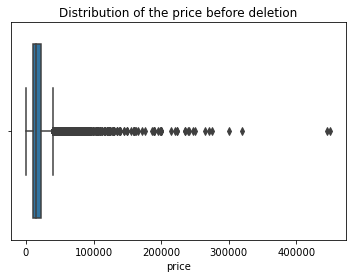

In [9]:
#Investigate price 
price = auto_data.price
sns.boxplot(price)
plt.title("Distribution of the price before deletion")
plt.show()
#so many outliers!

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


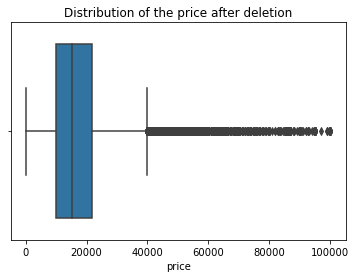

In [10]:
#We normally would vehicles over the 99th percentile to get rid of outliers but as this our explanatory variable
# so we eliminate vehicle's whose price is double the current 99th percentile of price
auto_data= auto_data[auto_data.price< 100000 ]
price = auto_data.price
sns.boxplot(price)
plt.title("Distribution of the price after deletion")
plt.show()

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


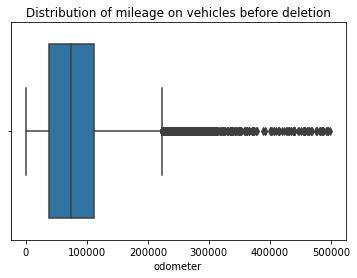

In [11]:
#Investigate Mileage
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles before deletion")
plt.show()
#so many outliers!

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


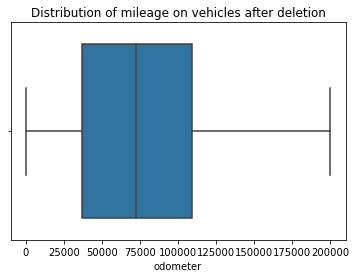

In [12]:
#We eliminate vehicles over the 99th percentile
auto_data= auto_data[auto_data.odometer< 200000 ]
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles after deletion")
plt.show()

In [ ]:
#Investigate Average Mileage
# Average Milage is the mileage divided by the age let's see that relationship 
g = sns.jointplot(x= 'age', y='odometer',data=auto_data , kind='kde')
_ = g.title = 'Age vs Mileage'
#We van see clustered Non Linear replationsip between age and mileage and some pretty clear boundries

In [ ]:
#Investigate Average Mileage using boxplot
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
#so many outliers!

In [ ]:
#We eliminate vehicles over the 99th percentile
auto_data= auto_data[auto_data.Avg_Mileage< 60000]
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles after deletion")
plt.show()
plt.show()

In [ ]:
#Check Cylinders
#Investigate cylinders
cylinders = auto_data.cylinders
sns.boxplot(cylinders)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
cylinders.value_counts()
#We eliminate 12 as it only has one value 
auto_data =  auto_data[auto_data['cylinders']<12]


In [ ]:
#There is an interesting relationship between cylinders, and drive
size_type_table = pd.crosstab(index=auto_data["drive"], columns=auto_data["cylinders"])
plt.figure(figsize=(14,12))
size_type_table.plot(kind="bar",  figsize=(8,8), stacked=True)
plt.show()

In [ ]:
#There is an interesting relationship between cylinders, drive, mileage and price
plt.figure(figsize=(14,12))
sns.catplot(x="cylinders", y="price", hue='drive', kind='point', data=auto_data)
plt.show()

In [ ]:
g = sns.lmplot(x= 'odometer', y='price', data=auto_data,  col="cylinders", hue='drive', col_wrap=3, scatter_kws={"alpha":.6, "s": 5})
g = (g.set( ylim=(0, 100000)))

In [ ]:
# More visuals regarding the distributions are in eda3

## Cleaning Category/ type
* Category refers to the type of design of the vehicle ( examplesedan, hatchback), and it is something people take into consideration while buying a vehicle
* However the naming convention for this is non standard across manufactuers ("pickup" vs "truck" refers to the same type from Ford and GM respectively)
* Considering there are many users on Craigslist even though type is often in the description of a vehicle sold the naming convention would not be consistent from one user description to the next. 
* The type would not  use consistent rules through out it. To fix this we used a third party (see above merge.
* While the third party gave us a map for some of the vehicle it did not give us all the vehicles.
* Further the third party when it did merge often gave us a group of categories the vehicle could belonged to which needs to be narrowed down what is specific for that vehicle
* We are going to try to use the third party's categories and what's in the user description to go for type
* For the merge's we have we are going to check if the category within the description matches what the third party gave


In [ ]:
#clean Category iin second option
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]


#see what Categories are listed by third party
print(auto_data.Category.unique())

#Using the results from Category see  if a category is mentioned in the craig's list description
cat_list= ['Sedan' , 'Convertible' , 'Coupe' , 'Hatchback' , 'Pickup' , 'Wagon',  'Van' ,'Minivan',  'SUV']
auto_data['cat_tiki']= ''

# Find if Category is description saveas cat_tiki
for cat in cat_list:
    auto_data['cat_tiki']=np.where(auto_data.description.str.contains(cat , case=False, na=False), cat, '')
auto_data.info()

In [ ]:
# We aregoing to create a column Category Cleaned which has the imputed values for Category

#We need this to iterate
auto_data['cat_tiki_check0']= ''
auto_data['cat_tiki_check1']= ''
auto_data['cat_tiki_check2']= ''
auto_data['Category_Cleaned']= auto_data['Category2']
auto_data['cat_tiki_cleaned1']= auto_data['Category2']
auto_data['Category3'] =  auto_data['Category'].fillna('') 
auto_data['type3'] =  auto_data['type'].fillna('') 
auto_data['type4'] =  auto_data['type']
print(auto_data.info())

In [ ]:

#the data set came also with "type" which... I haven't seen the rules for so we are going to use it as a possible source.

#check if vehicle type listed in description is the sameone that is in the data 
auto_data['cat_tiki_check0']= auto_data.apply(lambda x: x.cat_tiki in x.type3, axis=1)

#Simiplify cat_tiki so that it makes an easier match
auto_data.loc[auto_data['cat_tiki_check0'] == True, 'type3'] = auto_data.cat_tiki

#check if vehicle type listed in description is in the third party group if there is a 3rd party group
auto_data['cat_tiki_check1']= auto_data.apply(lambda x: x.cat_tiki in x.Category3, axis=1)

#Where a Category in the description is in the third party's group of Category update values to reflect this match
auto_data.loc[auto_data['cat_tiki_check1'] == True, 'Category_Cleaned'] = auto_data.cat_tiki
auto_data2=auto_data

print(auto_data.info())


In [ ]:

#check if vehicle type listed in data is in categories use type that was also one of the one's listed by the third party
auto_data['cat_tiki_check2']= auto_data.apply(lambda x: x.type3 in x.Category3, axis=1)

#Switch the value in Category cleaned to the one that was included in type
auto_data.loc[auto_data['cat_tiki_check2'] == True, 'cat_tiki_cleaned1'] = auto_data.type


auto_data['Category_Cleaned'].fillna('cat_tiki_cleaned1',inplace = True)

#get rid of variables included only for iteration
auto_data= auto_data.drop(['Category3', 'type3', 'type4', 'cat_tiki_check0', 'cat_tiki_check1', 'cat_tiki_check2', 'cat_tiki_cleaned1' ], axis=1)

auto_data.info()

In [ ]:
new_file = 'auto_data_imputed_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Dropping Categorical Variables
* We want to reduce the number of unnecessary variables. Bellow are some of the reasons:
* We Eliminate categorical variables that are included in another variable (aka intercorrelation)
    * example keeping Category_cleaned  means we can get rid of Category, Category1, type, and cat_tiki
* We Eliminate categorical variables that are either unique to each vehicle (not counding id) or have too many categories within it because that would create too many dummy variables 
    * Descriptions and Vins are unique to each vehicle we can eliminate both variables
    * There are over 400 regions while this could be an interesting study we don't need it. It might be something to look into for another study
    * There are over 10000 models and while models are not completely unique to each vehicle considering we are trying to determine the asking price when we don't know the value of the model it goes around the point of the study. However again it could be something to look into.
* We eliminate variables that have only one value as the don't add anything to the model
    * title status
*  We have state data, as well as  long and lat therefore we get rid of the 50 state dummy variables this could be re included

In [ ]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

In [ ]:
#drop variables due to intercorrelation to Category Cleaned

z2= auto_data.drop(columns=['Category', 'Category1', 'Category2', 'cat_tiki'] )

#drop categorical variables unique to each entry and/or having over 100 categories within
z2 =z2.drop(columns= ['region', 'model', 'description', 'vin' ], axis=1)

#drop state due to combo of intercorrelation and too many variables
z2 =z2.drop(columns= ['state'], axis=1)

#drop to having only 1 value
z2 =z2.drop(columns= ['title_status'], axis=1)



In [ ]:
tes = z2[z2.manufacturer == 'Tesla']
tes.drive.mode()[0]
print(tes.count())
z2.loc[(z2.manufacturer == 'Tesla') & (z2['drive'].isna()), 'drive'] = 'rwd' 


In [ ]:

print(tes.count())
z2.loc[(z2.manufacturer == 'Tesla') & (z2['drive'].isna()), 'drive'] = 'rwd' 
z2.loc[(z2.manufacturer == 'Tesla') & (z2['size'].isna()), 'size'] = 'mid-size' 
tes = z2[z2.manufacturer == 'Tesla']
print(tes.count())
print(tes.isnull().sum())

In [ ]:
z2.manufacturer.value_counts()

In [ ]:
print(z2.isnull().sum())

In [ ]:
#Dropping Nulls- We prefer our data to be without nulls with the exception of MSRP and resid there are few nulls so we eliminate those

z2= z2.dropna(subset=['id', 'price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'transmission', 'drive', 'paint_color', 'lat',
       'long', 'age', 'Avg_Mileage', 'Category_Cleaned'])
z2.manufacturer.value_counts()

In [ ]:
z2.manufacturer.value_counts()
#drop if less than 10 in the category
z2 = z2[z2.manufacturer != 'Ferrari']
z2 = z2[z2.manufacturer != 'Porche']
z2 = z2[z2.manufacturer != 'Aston-Martin']
z2 = z2[z2.manufacturer != 'Land-Rover']
#We are not loooking up superluxury cars aka
z2.manufacturer.value_counts()


In [ ]:
print(z2.isnull().sum())

## Eliminate variables due to intercorrelation

In [ ]:
#plot correlation
plt.figure(figsize=(14,12))
sns.heatmap(z2.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

## Chosing Scaler Standardization

#### Standizing Data
* We have a few methods of standardization to choose from: Robust, Minmax, Normalize and Standardize
* We use Robust if we want to minimize impact of outliers
* We use Normalize if we think the distrubtion within a variable needs to be normalized and/or has a normal distribution
* We use Standardize when we think most of the variables have similar distribution and no/few dummy variables

In [ ]:
hist = z2.hist(figsize=(40,22))
#The data for price is and age are not a normal destribution so both normalize scaler is bad idea 

In [ ]:
z3 = z2.drop(columns=['id', 'MSRP', 'resid'])
boxplot = z3.boxplot(grid=False, vert=False,fontsize=9)
#No large outliers as that was cleaned out already earlier will not use Robust Scaler

#### Choosing Min Max Scaler
* The data for price is and age are not a normal destribution we eliminate normalize scaler
* No large outliers as that was cleaned out already earlier we eliminate  Robust Scaler
* As we have dummy variables we can eliminate standard scaler 
* That leaves us with Min Max Zx

## Create Dummy Variables

In [ ]:
#create dummy variables
auto_data_dummies= pd.get_dummies(z2)
auto_data_dummies.info()

In [ ]:
#check correlation between some dummy variables
auto_data_cats= z2[['transmission', 'cylinders', 'fuel', 'drive', 'Category_Cleaned']]
auto_data_dummies_small= pd.get_dummies(auto_data_cats)


plt.figure(figsize=(14,12))
sns.heatmap(auto_data_dummies_small.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')


## Seperate Data for Test and Trial

In [ ]:

#seperate X and y from each other
X = auto_data_dummies
print(type(X))
y = auto_data_dummies['price']

X =X.drop(columns=['price', 'id'], axis=1)
X.info()


In [ ]:

#split train, trial and vals

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)

X_train.info()

# Create val and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 3/11)

## Scale data vased on previous data

In [ ]:
#after new kernall and cc clean

"""
Data Cleaned to cell 17 (run time 3 minutes)
Data to cell 46 (run time another 4 minutes)
Data to cell 47 (run time another 1 minute)
Data to cell 48 (run time another 4 minute)
Data to cell 55 (run time another 2 minute)
Total: 14 minutes
"""

#first Checkpoint
"""
Data Cleaned to cell 60 (1 minute)
Data Cleaned to cell 68 (7 minute)
Data Cleaned to cell 69 (1 minute)
Data Cleaned to cell 75 (4 minute)
Data Cleaned to cell 91 (2 minute)
"""

In [ ]:
#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#create scaler
scaler = MinMaxScaler()
scaler_sc = StandardScaler()

#Scale numeric data1
X_train_mm = scaler.fit_transform(X_train)
X_val_mm = scaler.transform(X_val)
X_test_mm = scaler.transform(X_test)

In [ ]:
type(X_train)
print(type(X_train.columns.tolist()))

In [ ]:
df_cl_list=X_train.columns.tolist()
df3 = pd.DataFrame(X_train_mm, columns = df_cl_list)
df3 = df3.iloc[:, : 10]
df3.describe()

In [ ]:
boxplot = df3.boxplot(grid=False, vert=False,fontsize=9)

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.0001, solver='cholesky')

#Instantiate and fit a ridge reg to the min_max scaled data
ridge_scaled = ridge.fit(X_train_mm, y_train)


# Instantiate and fit ridge reg classifier to the unscaled data
ridge_unscaled = ridge.fit(X_train, y_train)

y_pred_mm = ridge_scaled.predict(X_val_mm)
y_pred = ridge_unscaled.predict(X_val)

# Compute and print metrics
print('Accuracy with Min Max Scaling: {}'.format(ridge_scaled.score(X_val_mm, y_val)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_val, y_val)))


## Testing Models

### Ridge Regression

In [ ]:
# Testing different Ridge Regressions
params_Ridge = {'alpha': [0.1,0.01,0.001,0.0001] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr']}
ridge_reg = Ridge()
Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, cv=5, verbose=8)

Ridge_GS.fit(X_train_mm, y_train)
print('For non scaled data using Ridge Regression')
print('Best Score: {}'.format(Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))

In [ ]:
Ridgeregression = Ridge(random_state=42, **Ridge_GS.best_params_)
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=Ridgeregression, X=X_train_mm, y=y_train, cv=5)
print(all_accuracies)

Ridgeregression.fit(X_train_mm, y_train)
ridge_score= Ridgeregression.score(X_val_mm, y_val)

print('Ridge using outside test_data : {}'.format(ridge_score))


### Testing Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression

Cs = [0.0001, 0.001, 0.005, 0.1,  1, 2, 10, 100, 1000]
clf_scores =[]
clf_C_dict = {}


clf = LogisticRegression()
# Fit the model on the trainng data.

param_grid = {'C': Cs}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(clf, param_grid, cv=5, verbose=8)


In [ ]:
# Fit it to the data
logreg_cv.fit(X_train_mm,y_train)



print('For Min Max scaled data using Logistic  Regression')
print('Best Score: {}'.format(logreg_cv.best_score_))
print('Best estimator: {}'.format(logreg_cv.best_estimator_))
print('Best parameters: {}'.format(logreg_cv.best_params_))

In [ ]:

LogisticRegression_t = clf(random_state=42, **logreg_cv.best_params_)
all_accuracies_lg = cross_val_score(estimator= LogisticRegression_t, X=X_train_mm, y=y_train, cv=5)
print(all_accuracies_lg)

LogisticRegression_t.fit(X_train_mm, y_train)
LogisticRegression_t.score(X_val_mm, y_val)


log_score= LogisticRegression_t.score(X_val_mm, y_val)
print('Logistic using outside test_data : {}'.format(log_score))


In [ ]:
### Testing Linear Regression

In [ ]:
model = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=None)
grid.fit(X_train, y_train)
print "r2 / variance : ", grid.best_score_
print("Residual sum of squares: %.2f"
              % np.mean((grid.predict(X_test) - y_test) ** 2))

print('For Min Max scaled data using Linear  Regression')
print('Best Score: {}'.format(grid.best_score_))
print('Best estimator: {}'.format(grid.best_estimator_))
print('Best parameters: {}'.format(grid.best_params_))

In [ ]:
LinearRegression_t = model(random_state=42, **grid.best_params_)
all_accuracies_lin = cross_val_score(estimator= LinearRegression_t, X=X_train_mm, y=y_train, cv=5)
print(all_accuracies_lin)

LinearRegression_t.fit(X_train_mm, y_train)
LinearRegression_t.score(X_val_mm, y_val)

lin_score= LinearRegression_t.score(X_val_mm, y_val)
print('Logistic using outside test_data : {}'.format(lin_score))


### Logistic PCA chained

In [ ]:

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

model = linear_model.LinearRegression()

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [15, 30, 45, 64, 100, 108],
    'linear__fit_intercept':[True,False],
    'linear__normalize':[True,False],
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

print('For Min Max scaled data using chained PCA and Linear  Regression')
print('Best Score: {}'.format(search.best_score_))
print('Best estimator: {}'.format(search.best_estimator_))
print('Best parameters: {}'.format(search.best_params_))

# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

In [ ]:
clf_t = pipe(random_state=42, **search.best_params_)
all_accuracies_pipe = cross_val_score(estimator= clf_t, X=X_train_mm, y=y_train, cv=5)
print(all_accuracies_pipe)

clf_t.fit(X_train_mm, y_train)
clf_t.score(X_val_mm, y_val)

clf_t_score= clf_t_t.score(X_val_mm, y_val)
print('Logistic using outside test_data : {}'.format(clf_t_score))